Annex
===

In [1]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline
import numpy as np
from numpy import exp, sqrt, log, pi
from scipy.optimize import curve_fit
from scipy.stats import chi2
from scipy import odr
from scipy.integrate import quad
from scipy.signal import find_peaks
from scipy.signal import argrelextrema, argrelmin, argrelmax


def fehler(name, G, sig_G, G_lit, sig_G_lit):
    print(name)
    print('Relativer Fehler: ', sig_G / G * 100)
    print('Rel. Fehler (Vergleich):', sig_G_lit / G_lit * 100)
    print('Absoluter Fehler: ', G - G_lit)
#    print('Verhältnis:', G / G_lit)
    print('Sigma-Abweichung: ', np.abs(G - G_lit) / sqrt(sig_G ** 2 
                                                         + sig_G_lit ** 2),'\n')
    
    
def fehler_small(name, G, sig_G):
    print(name)
    print('Relativer Fehler: ', sig_G / G * 100)
    

def ergebnis(name, G, sig_G, komma, einheit):
    print(name + ' =', np.round(G, komma), '+/-', np.round(sig_G, komma), einheit)
    

def ergebnis_large(name, G, sig_G, komma, einheit):
    print(name + ' =', np.round(G, komma))
    print('+/-'.rjust(len(name) + 2), np.round(sig_G, komma), einheit)
    

def fitparameter(name, G, sig_G, komma, einheit):
    return name + ' = ' + str(np.round(G, komma)) + '$\pm$' + str(np.round(sig_G, komma)) + einheit

Determination of the viscosity after Stokes with a falling sphere viscometer 
--

Measurements

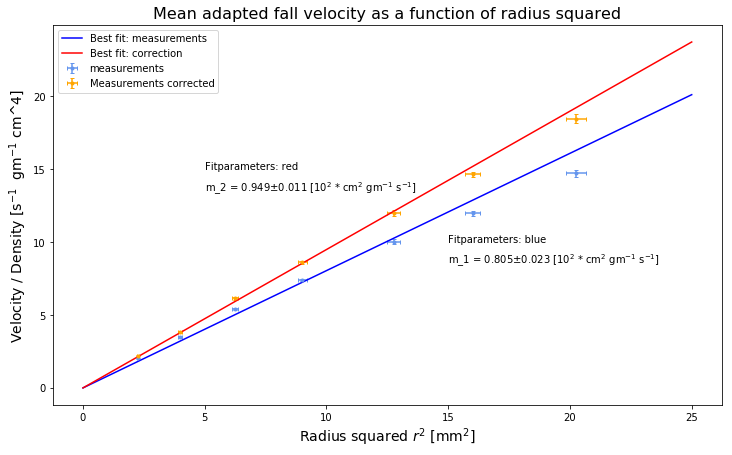

In [32]:
radius = np.array([3, 4, 1.5, 2, 5, 6, 7.144, 8, 9]) / 2 # cm

mask = np.ones(len(radius), dtype = bool) # Remove problematic 1.5, 2 diameter
mask[[2, 3]] = False

radius = radius[mask, ...]

sig_radius = radius * 0.01
radius_sq = radius ** 2
sig_radius_sq = 2 * radius * sig_radius

distance = np.array([50, 50, 5, 5, 100, 100, 100, 100, 100]) / 10 # cm
distance = distance[mask, ...]

falltime = np.array([np.array([11.31, 10.72, 10.31, 10.82, 10.26]), 
                     np.array([6.39, 6.48, 6.21, 6.29, 6.04]),
                     np.array([7.72, 7.23, 7.29, 7.75, 7.21]), 
                     np.array([4.90, 4.36, 4.58, 4.18, 4.44]),
                     np.array([8.06, 8.21, 8.02, 8.17, 7.95]),
                     np.array([5.90, 5.93, 5.92, 5.81, 5.89]),
                     np.array([4.46, 4.34, 4.26, 4.19, 4.48]),
                     np.array([4.01, 4.00, 3.95, 3.95, 4.00]),
                     np.array([3.07, 3.14, 3.24, 3.10, 3.26])]) # s 
falltime = falltime[mask, ...]

# Density of balls
rho_k = np.array([1.3775, 1.3775, 1.3775, 1.3775, 1.3775, 1.3775, 1.3775,
               1.3575, 1.3625]) # g cm^-3
rho_k = rho_k[mask, ...]
sig_rho_k = 0.0025
# Density of polyethylene
rho_pol = 1.1478 # g cm^-3
sig_rho_pol = 0.0002
# Density difference
rho = rho_k - rho_pol
sig_rho = sqrt( (sig_rho_k) ** 2 + (sig_rho_pol) ** 2 )

R = 75 / 2 # mm


# Mean velocity
v_mean = np.array([np.mean(distance[i] / falltime[i]) 
                   for i in range(len(distance))]) # cm s^-1
sig_v_mean = np.array([1 / sqrt(5 - 1) * np.std(distance[i] / falltime[i]) 
                       for i in range(len(distance))])

v_mean_rho = v_mean / rho
sig_v_mean_rho = v_mean_rho * sqrt( (sig_v_mean / v_mean) ** 2 + (sig_rho / rho) ** 2 )

# Correction term
lambda_k = (1 + 2.1 * (radius / R))
sig_lambda_k = 2.1 / R * sig_radius
v_mean_r_l = v_mean_rho * lambda_k
sig_v_mean_r_l = sqrt( (sig_v_mean_rho * lambda_k) ** 2 
                      + (v_mean_rho * sig_lambda_k) ** 2 )

# Fit
def line(x, m):
    return m * x 

popt_1, pcov_1 = curve_fit(line, radius_sq, v_mean_rho, sigma = sig_v_mean_rho)

m_1 = popt_1[0]
#b_1 = popt_1[1]
sig_m_1 = sqrt(pcov_1[0, 0])
#sig_b_1 = sqrt(pcov_1[1, 1])

popt_2, pcov_2 = curve_fit(line, radius_sq, v_mean_r_l, sigma = sig_v_mean_r_l)

m_2 = popt_2[0]
#b_2 = popt_2[1]
sig_m_2 = sqrt(pcov_2[0, 0])
#sig_b_2 = sqrt(pcov_2[1, 1])

x = np.linspace(0, 25, 101)

# Plot
plt.figure(figsize = (12, 7))
plt.title('Mean adapted fall velocity as a function of radius squared',
          size = 16)
# Uncorrected
plt.errorbar(radius_sq, v_mean_rho, xerr = sig_radius_sq, yerr = sig_v_mean_rho, 
             fmt = '.', capsize = 2, label = 'measurements', color = 'cornflowerblue')
plt.plot(x, line(x, *popt_1), label = 'Best fit: measurements', color = 'blue')
plt.text(15, 10, 'Fitparameters: blue')
plt.text(15, 8.5, fitparameter('m_1', m_1, sig_m_1, 3, 
                             ' [10$^2$ * cm$^2$ gm$^{-1}$ s$^{-1}$]'))
#plt.text(65, 7, fitparameter('b_1', b_1, sig_b_1, 2, 
 #                            ' [cm$^4$ gm$^{-1}$ s$^{-1}$]'))

# Corrected
plt.errorbar(radius_sq, v_mean_r_l, xerr = sig_radius_sq, yerr = sig_v_mean_r_l, 
            fmt = '.', capsize = 2, label = 'Measurements corrected', color = 'orange')
plt.plot(x, line(x, *popt_2), label = 'Best fit: correction', color = 'red')
plt.text(5, 15, 'Fitparameters: red')
plt.text(5, 13.5, fitparameter('m_2', m_2, sig_m_2, 3, 
                             ' [10$^2$ * cm$^2$ gm$^{-1}$ s$^{-1}$]'))
#plt.text(10, 12, fitparameter('b_2', b_2, sig_b_2, 2, 
 #                            ' [cm$^4$ gm$^{-1}$ s$^{-1}$]'))
plt.xlabel('Radius squared $r^2$ [mm$^2$]', size = 14)
plt.ylabel('Velocity / Density [s$^{-1}$  gm$^{-1}$ cm^4]',
          size = 14)
plt.legend(loc = 'upper left')

plt.savefig('images/212/V212Diagramm1.png')

In [33]:
# Good of the fit: blue
chi2_= np.sum((line(radius_sq, *popt_1) - v_mean_rho) ** 2 
              / sig_v_mean_rho ** 2) 
dof = len(sig_v_mean_rho) - 1 #dof:degrees of freedom, Freiheitsgrad 
chi2_red = chi2_/dof

print("chi2 =", chi2_)
print("chi2_red =",chi2_red)

prob = np.round(1 - chi2.cdf(chi2_,dof),2) * 100 
print("Probability =", prob, "%")

chi2 = 159.07396182485218
chi2_red = 26.512326970808697
Probability = 0.0 %


In [34]:
# Good of the fit: red
chi2_= np.sum((line(radius_sq, *popt_2) - v_mean_r_l) ** 2 
              / sig_v_mean_r_l ** 2) 
dof = len(sig_v_mean_r_l) - 1 #dof:degrees of freedom, Freiheitsgrad 
chi2_red = chi2_/dof

print("chi2 =", chi2_)
print("chi2_red =",chi2_red)

prob = np.round(1 - chi2.cdf(chi2_,dof),2) * 100 
print("Probability =", prob, "%")

chi2 = 26.409693714750645
chi2_red = 4.401615619125107
Probability = 0.0 %


Viscosity

In [35]:
g = 9.81 # m s^-2
eta_1 = 2 * g / (9 * m_1)
eta_2 = 2 * g / (9 * m_2)
sig_eta_1 = eta_1 * sqrt( (sig_m_1 / m_1) ** 2 )
sig_eta_2 = eta_2 * sqrt( (sig_m_2 / m_2) ** 2 )

ergebnis('eta_1', eta_1, sig_eta_1, 2, '[g cm^-1 s^-1]')
ergebnis('eta_2 (corr)', eta_2, sig_eta_2, 3, '[g cm^-1 s^-1]')

eta_1 = 2.71 +/- 0.08 [g cm^-1 s^-1]
eta_2 (corr) = 2.296 +/- 0.026 [g cm^-1 s^-1]


Reynolds number

In [36]:
Re = rho_pol * v_mean * 2 * radius / eta_2 * 1e-1
sig_Re = Re * sqrt( (sig_rho_pol / rho_pol) ** 2 
                   + (sig_v_mean / v_mean) ** 2 
                   + (sig_radius / radius) ** 2 
                   + (sig_eta_2 / eta_2) ** 2)

print('Correspondnig radius ', radius, '[mm]')
ergebnis_large('Reynolds number: Re', Re, sig_Re, 3, '')

Correspondnig radius  [1.5   2.    2.5   3.    3.572 4.    4.5  ] [mm]
Reynolds number: Re = [0.07  0.159 0.309 0.509 0.822 1.004 1.424]
                  +/- [0.002 0.003 0.005 0.008 0.016 0.016 0.028] 


Laminar velocity

radius:  [1.5   2.    2.5   3.    3.572 4.    4.5  ] [mm]
v_mean = [0.469 0.796 1.237 1.698 2.302 2.511 3.164]
     +/- [0.008 0.01  0.007 0.006 0.03  0.008 0.038] [cm s^-1]
v_lam = [0.491 0.872 1.363 1.963 2.782 3.185 4.128]
    +/- [0.013 0.022 0.035 0.05  0.071 0.083 0.107] [cm s^-1]
vv_lam = [0.955 0.913 0.908 0.865 0.828 0.788 0.767]
     +/- [0.031 0.028 0.026 0.026 0.029 0.026 0.028] 


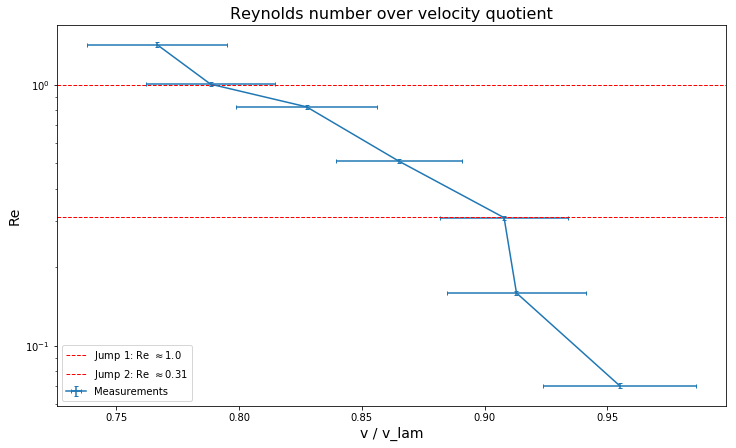

In [37]:
v_lam = 2 / 9 * g * radius_sq * rho / eta_2 
sig_v_lam = v_lam * sqrt( (sig_radius_sq / radius_sq) ** 2 
                         + (sig_rho / rho) ** 2 
                         + (sig_eta_2 / eta_2) ** 2)
print('radius: ', radius, '[mm]')
ergebnis_large('v_mean', v_mean, sig_v_mean, 3, '[cm s^-1]')
ergebnis_large('v_lam', v_lam, sig_v_lam, 3, '[cm s^-1]')

# Plot
vv_lam = v_mean / v_lam
sig_vv_lam = sqrt( (sig_v_mean / v_mean) ** 2 
                  + (sig_v_lam / v_lam) ** 2 )

ergebnis_large('vv_lam', vv_lam, sig_vv_lam, 3, '')

plt.figure(figsize = (12, 7))
plt.errorbar(vv_lam, Re, xerr = sig_vv_lam, yerr = sig_Re, fmt = '-', 
             capsize = 2, label = 'Measurements')
plt.yscale('log')
plt.title('Reynolds number over velocity quotient', size = 16)
plt.xlabel('v / v_lam', size = 14)
plt.ylabel('Re', size = 14)
hor2 = 3.1e-1
hor1 = 1e0
plt.axhline(hor1, linestyle = '--', color = 'red', linewidth = 1, 
            label = 'Jump 1: Re $\\approx$' + str(hor1))
plt.axhline(hor2, linestyle = '--', color = 'red', linewidth = 1, 
            label = 'Jump 2: Re $\\approx$' + str(hor2))
plt.legend(loc = 'best')

plt.savefig('images/212/V212Diagramm2.png')

Determination of the viscosity after Hagen-Poiseuille with a capillary viscometer
--

Measurements

In [38]:
volume = np.linspace(5, 25, 5) # cm^3
timesteps = np.array([92, 238, 387, 550, 688]) # s
sig_time = 2.5
vol_initial = 509 # mm
vol_final = 501
sig_vol = 0.5

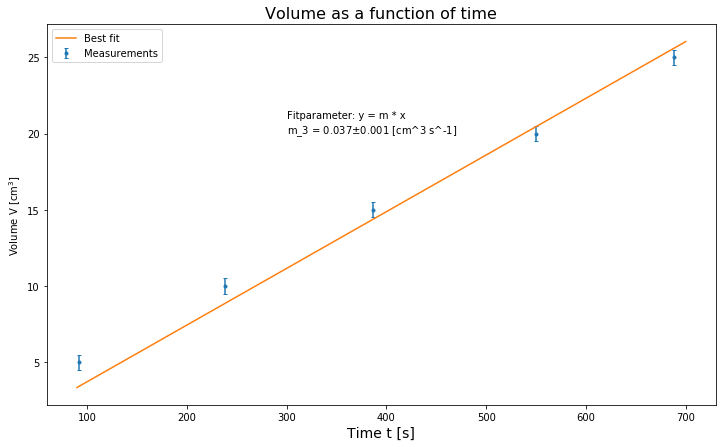

In [39]:
# Fit
popt_3, pcov_3 = curve_fit(line, timesteps, volume)

m_3 = popt_3[0] # cm^3 s^-1
sig_m_3 = sqrt(pcov_3[0, 0])

t = np.linspace(90, 700, 200)

# Plot
plt.figure(figsize = (12, 7))
plt.errorbar(timesteps, volume, yerr = sig_vol, fmt = '.', capsize = 2,
            label = 'Measurements')
plt.plot(t, line(t, *popt_3), label = 'Best fit')
plt.text(300, 21, 'Fitparameter: y = m * x')
plt.text(300, 20, fitparameter('m_3', m_3, sig_m_3, 3, ' [cm^3 s^-1]'))
plt.title('Volume as a function of time', size = 16)
plt.xlabel('Time t [s]', size = 14)
plt.ylabel('Volume V [cm$^3$]')
plt.legend(loc = 'best')

plt.savefig('images/212/V212Diagramm3.png')

In [40]:
# Good of the fit: orange
chi2_= np.sum((line(timesteps, *popt_3) - volume) ** 2 
              / sig_vol ** 2) 
dof = len(volume) - 1 #dof:degrees of freedom, Freiheitsgrad 
chi2_red = chi2_/dof

print("chi2 =", chi2_)
print("chi2_red =",chi2_red)

prob = np.round(1 - chi2.cdf(chi2_,dof),2) * 100 
print("Probability =", prob, "%")

chi2 = 18.925005122531953
chi2_red = 4.731251280632988
Probability = 0.0 %


Viscosity

In [41]:
dVdt = m_3 # cm^3 s^-1
sig_dVdt = sig_m_3
hbar = (vol_initial + vol_final) / 2 # mm
sig_hbar = sqrt(2) / 2 * sig_vol

Delta_p = rho_pol * g * hbar # Pa
sig_Delta_p = rho_pol * g * sig_hbar

R = 1.5 / 2 # mm
sig_R = 0.01 / 2
L = 100 # mm
sig_L = 0.5

eta_hp = pi * Delta_p * R ** 4 / (8 * L * dVdt) * 1e-3 # Pa s
sig_eta_hp = eta_hp * sqrt( (sig_Delta_p / Delta_p) ** 2 + (4 * sig_R / R) ** 2 
                           + (sig_L / L) ** 2 + (sig_dVdt / dVdt) ** 2)

ergebnis('eta_hp', eta_hp, sig_eta_hp, 3, '[Pa s]')

eta_hp = 0.19 +/- 0.008 [Pa s]


Reynold's number

In [42]:
v_A = dVdt / (pi * R ** 2)
sig_v_A = v_A * sqrt( (sig_dVdt / dVdt) ** 2 + (2 * sig_R / R) ** 2 )
Re_hp = rho_pol * v_A * R / eta_hp
sig_Re_hp = Re_hp * sqrt( (sig_rho_pol / rho_pol) ** 2 + (sig_v_A / v_A) ** 2 
                         + (sig_L / L) ** 2 + (sig_eta_hp / eta_hp) ** 2)

ergebnis('Re_hp', Re_hp, sig_Re_hp, 3, '')

Re_hp = 0.095 +/- 0.005 


Sigmas
--

In [43]:
# Viskosität
fehler('eta', 1e-1 * eta_2, 1e-1 * sig_eta_2, eta_hp, sig_eta_hp)

eta
Relativer Fehler:  1.1507098108390523
Rel. Fehler (Vergleich): 3.9997486817598626
Absoluter Fehler:  0.039647596117293155
Sigma-Abweichung:  4.928246283960424 

